In [133]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.mappings import PT_value_mapping
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping
from src.utils import download_data


In [134]:
new = TSD(file_path='../datasets/100_yr_dataset.xlsx')

Dataset loaded from ../datasets/100_yr_dataset.xlsx


In [135]:
# initialize dataset by downloading dataset or downloading the data from polity_url
dataset = TSD(categories=['sc'], template_path='../datasets/SC_WF_MSP_template.csv')
dataset.add_polities()

url = "https://seshat-db.com/api/crisisdb/power-transitions/"
pt_df = download_data(url)
pt_df.reset_index(drop=True, inplace=True)

PT_types = ['overturn', 'predecessor_assassination', 'intra_elite',
       'military_revolt', 'popular_uprising', 'separatist_rebellion',
       'external_invasion', 'external_interference']
for type in PT_types:
    pt_df[type] = pt_df[type].apply(lambda x: PT_value_mapping[x] if x in PT_value_mapping.keys() else np.nan)

for type in PT_types:
    dataset.raw[type] = np.nan

dataset.raw['duration'] = np.nan

for idx, row in pt_df.iterrows():
    polity = row['polity_id']
    # check if polity is in dataset 
    if polity not in dataset.raw.PolityID.unique():
        print(f"Polity {row['polity_new_name']} in PT dataset but not in polity dataset")
        continue
    # get year
    year_from = row['year_from']
    year_to = row['year_to']
    if pd.notna(year_from) and pd.notna(year_to):
        year = year_to
        duration = year_to - year_from
    elif pd.notna(year_from) and pd.isna(year_to):
        year = year_to
        duration = np.nan
    elif pd.isna(year_from) and pd.notna(year_to):
        year = year_from
        duration = np.nan
    elif pd.isna(year_from) and pd.isna(year_to):
        year = row[['polity_start_year','polity_end_year']].mean()
        duration = np.nan

    if pd.isna(year):
        continue
    # add years to dataset
    dataset.add_years(polID=polity, year=year)
    # add PT types
    for col in PT_types:
        dataset.raw.loc[(dataset.raw.PolityID == polity)&(dataset.raw.Year==year), col] = row[col]
    dataset.raw.loc[(dataset.raw.PolityID == polity)&(dataset.raw.Year==year), 'duration'] = duration
dataset.raw = dataset.raw.loc[(dataset.raw.Year.notna())]


Loaded template from ../datasets/SC_WF_MSP_template.csv
Downloaded 863 rows
Downloaded 3448 rows


In [136]:
dataset.scv_imputed = dataset.raw.copy()

In [137]:
dataset_100y = TSD(file_path='../datasets/100_yr_dataset.xlsx')

Dataset loaded from ../datasets/100_yr_dataset.xlsx


In [138]:
dataset_100y.scv['Hierarchy_sq'] = dataset_100y.scv['Hierarchy']**2
scale_cols = ['Pop','Terr','Cap','Hierarchy', 'Hierarchy_sq']
dataset_100y.impute_missing_values(scale_cols, use_duplicates = False)
non_scale_cols = ['Government', 'Infrastructure', 'Information', 'Money']
dataset_100y.impute_missing_values(non_scale_cols, use_duplicates = False)

No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap
No best overlap found for Pop
No best overlap found for Terr
No best overlap found for Cap

In [139]:
from sklearn.linear_model import LinearRegression
scale_cols = ['Pop','Terr','Cap']
dataset_100y.compute_PCA(cols = scale_cols, col_name = 'Scale', n_cols = 1, n_PCA= len(scale_cols), contributions=True, rescale=True)

# Fit linear model to rescale the PCA according to variable Pop
lm_df = dataset_100y.scv_imputed[['Pop', 'Scale_1']].dropna()

# rescale the PCA according to variable Pop
lm = sm.OLS(lm_df['Scale_1'], lm_df['Pop']).fit()
X = lm_df[['Pop']]
y = lm_df['Scale_1']

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Extract the coefficients
intercept = model.intercept_
slope = model.coef_[0]

# Adjust the Scale_1 column
dataset_100y.scv_imputed['Scale_1'] = (dataset_100y.scv_imputed['Scale_1'] - intercept) / slope

dataset_100y.scv_imputed['Comp'] = (dataset_100y.scv_imputed['Government']*11 + dataset_100y.scv_imputed['Infrastructure']*12 + dataset_100y.scv_imputed['Information']*13 + dataset_100y.scv_imputed['Money']*6)/(11+13+12+6)

there are some NaNs in the imputed dataset
Explained variance by each PC:
PC1: 90.65%
PC2: 6.80%
PC3: 2.55%
PC1 contributions:
Pop: -0.59
Terr: -0.57
Cap: -0.57


In [140]:
dataset.scv_imputed['Scale'] = np.nan
dataset.scv_imputed['Comp'] = np.nan
missin_pols = []

for index,row in dataset.scv_imputed.iterrows():
    year = row.Year
    polityID = row.PolityName

    if polityID not in dataset_100y.scv_imputed.PolityName.unique():
        missin_pols.append(polityID)
        continue
    temp_df = dataset_100y.scv_imputed[dataset_100y.scv_imputed.PolityName == polityID]
    if len(temp_df) == 1:
        dataset.scv_imputed.loc[index,'Scale'] = temp_df['Scale_1'].values[0]
        dataset.scv_imputed.loc[index,'Comp'] = temp_df['Comp'].values[0]

    else:
        years = temp_df['Year'].values
        # find closest year before row.year
        years_before = years[years < year]
        if len(years_before) == 0:
            closest_year = years[0]
        else:
            closest_year = years_before[np.argmax(years_before)]
        closest_year_row = temp_df[temp_df.Year == closest_year]
        dataset.scv_imputed.loc[index,'Scale'] = closest_year_row['Scale_1'].values[0]
        dataset.scv_imputed.loc[index,'Comp'] = closest_year_row['Comp'].values[0]



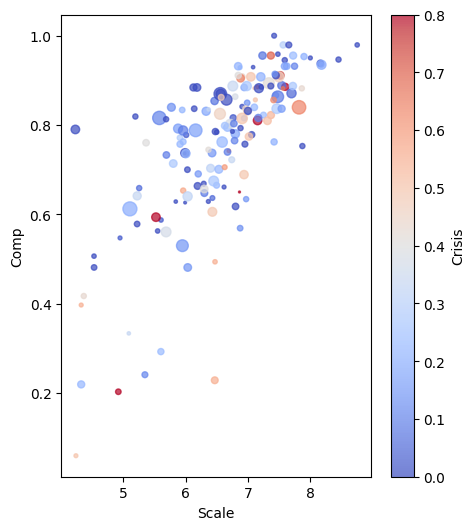

In [141]:
import matplotlib.pyplot as plt

dataset_plot = dataset.scv_imputed.copy()
polity_group = dataset_plot.groupby('PolityName')
fig, ax = plt.subplots(figsize=(5, 6))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale'].mean()
mean_crisis = polity_group['predecessor_assassination'].mean()
num_observations = polity_group.size()

threshold = 0.
if threshold > 0:
    mean_inst_1 = mean_inst_1.loc[mean_crisis > threshold]
    mean_scale_1 = mean_scale_1.loc[mean_crisis > threshold]
    num_observations = num_observations[mean_crisis > threshold]
    mean_crisis = mean_crisis.loc[mean_crisis > threshold]


v_max = mean_crisis.max()*0.8
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 2,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.show()

In [142]:
import statsmodels.api as sm

x_cols = ['Scale','Comp']
y_col = 'predecessor_assassination'
Xy = dataset.scv_imputed[[y_col]+x_cols].dropna()
Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col].apply(int)

linear_model = sm.OLS(y, X)
result = linear_model.fit()
print(result.summary())
logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())
# print pvalues
print(result.pvalues)

                                OLS Regression Results                               
Dep. Variable:     predecessor_assassination   R-squared:                       0.016
Model:                                   OLS   Adj. R-squared:                  0.015
Method:                        Least Squares   F-statistic:                     14.44
Date:                       Fri, 07 Feb 2025   Prob (F-statistic):           5.98e-07
Time:                               13:03:43   Log-Likelihood:                -876.32
No. Observations:                       1828   AIC:                             1759.
Df Residuals:                           1825   BIC:                             1775.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

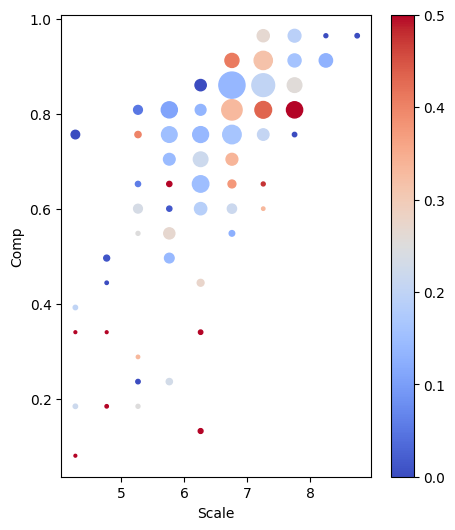

In [143]:
x_cols = ['Scale','Comp']
y_col = 'predecessor_assassination'
Xy = dataset_plot[[y_col]+x_cols].dropna()

x = Xy["Scale"].values
y = Xy["Comp"].values
z = Xy["predecessor_assassination"].values

grid_size = 20

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

# Define the grid
x_bins = np.linspace(0,10, grid_size + 1)
y_bins = np.linspace(0,1, grid_size + 1)

# Bin the data
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid = df.groupby(['x_bin', 'y_bin'])['z'].mean().unstack()
grid_std = df.groupby(['x_bin', 'y_bin'])['z'].std().unstack()
counts = df.groupby(['x_bin', 'y_bin'])['z'].count().unstack()

fig, ax = plt.subplots(figsize=(5, 6))
x,y = np.meshgrid(x_bins, y_bins)
plt.scatter(x.flatten(), y.flatten(), c=grid.T.values.flatten(), cmap='coolwarm', s=counts.T.values.flatten()*2, vmax = 0.5)
plt.colorbar()
plt.xlabel('Scale')

plt.ylabel('Comp')
# plt.title(crisis_vars)
plt.show()

In [151]:
dataset_pt_new = TSD(file_path='../datasets/25_yr_dataset.xlsx')

Dataset loaded from ../datasets/25_yr_dataset.xlsx


In [152]:
print(len(dataset_pt_new.scv))
dataset_pt_new.scv.drop_duplicates(subset = scale_cols + non_scale_cols, inplace = True)
print(len(dataset_pt_new.scv))

10235
859


In [90]:
dataset.save_dataset(path='../datasets/', name='pt_polaris_style')
pt_dat = pd.read_excel('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/Polaris_data.xlsx',sheet_name='PTdat')
polities_df = pd.read_excel('/Users/mperuzzo/Documents/repos/SeshatDatasetAnalysis/datasets/Polaris_data.xlsx',sheet_name='polities')

Dataset saved to ../datasets/pt_polaris_style.xlsx


In [100]:
pt_dat = pt_dat.dropna(subset=['assassin','Scale','Comp'])
pt_dat_new = dataset.scv_imputed.dropna(subset=['predecessor_assassination','Scale','Comp'])
print(len(pt_dat_new), len(pt_dat))

1828 1349


In [92]:
pt_dat['PolityName'] = pt_dat.PolID.apply(lambda x: polities_df.loc[polities_df.polity_old_ID == x, 'PolID'].values[0] if x in polities_df.polity_old_ID.values else print(x))

In [94]:
missing_polities = []
for pol in pt_dat_new.PolityName.unique():
    pol1 = pt_dat_new.loc[pt_dat_new.PolityName == pol,'Year']
    pol2 = pt_dat.loc[pt_dat.PolityName == pol,'year']
    polity_years = polities_df.loc[polities_df.PolID == pol, ['start_year','end_year']]
    print('\n' + pol + ' '+ str(polity_years.values[0]))
    print("Years in new dataset: ", pol1.values)
    print("Years in old dataset: ", pol2.values)
    if (len(pol2) == 0) and len(pol1) > 1:
        missing_polities.append(pol)


eg_old_k_1 [-2650 -2350]
Years in new dataset:  [-2613. -2589. -2566. -2532. -2503. -2487. -2475.]
Years in old dataset:  [-2613. -2589. -2566. -2532. -2503. -2487. -2475.]

iq_akkad_emp [-2270 -2083]
Years in new dataset:  [-2279. -2270. -2255. -2218. -2193. -2168. -2154.]
Years in old dataset:  [-2279. -2270. -2255. -2218. -2193. -2168. -2154.]

eg_old_k_2 [-2350 -2150]
Years in new dataset:  [-2287. -2278.]
Years in old dataset:  [-2287. -2278.]

eg_regions [-2150 -2016]
Years in new dataset:  [-2112. -2063. -2055. -2004.]
Years in old dataset:  [-2112. -2063. -2055. -2004.]

eg_middle_k [-2016 -1700]
Years in new dataset:  [-1992. -1956. -1911. -1877. -1870. -1831. -1786. -1777. -1773.]
Years in old dataset:  [-1992. -1956. -1911. -1877. -1870. -1831. -1786. -1777. -1773.]

eg_thebes_hyksos [-1720 -1567]
Years in new dataset:  [-1555. -1550.]
Years in old dataset:  [-1555. -1550.]

eg_new_k_1 [-1550 -1293]
Years in new dataset:  [-1525. -1504. -1492. -1479. -1473. -1458. -1425. -1

In [95]:
len(missing_polities)

46

3374
2762


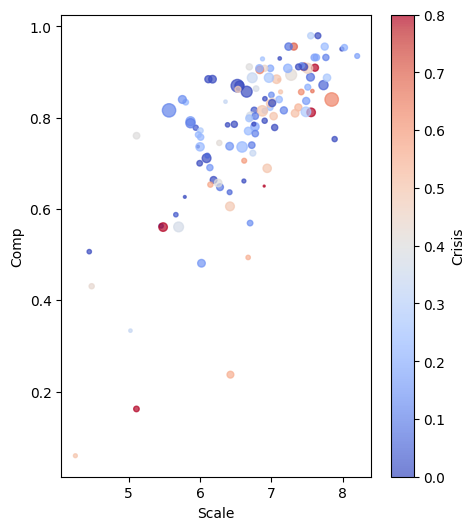

In [101]:
import matplotlib.pyplot as plt

dataset_plot = dataset.scv_imputed.copy()
print(len(dataset_plot))
dataset_plot = dataset_plot.loc[~dataset_plot.PolityName.isin(missing_polities)]
print(len(dataset_plot))
polity_group = dataset_plot.groupby('PolityName')
fig, ax = plt.subplots(figsize=(5, 6))
# Assuming polity_group is a DataFrame or GroupBy object
mean_inst_1 = polity_group['Comp'].mean()
mean_scale_1 = polity_group['Scale'].mean()
mean_crisis = polity_group['predecessor_assassination'].mean()
num_observations = polity_group.size()

threshold = 0.
if threshold > 0:
    mean_inst_1 = mean_inst_1.loc[mean_crisis > threshold]
    mean_scale_1 = mean_scale_1.loc[mean_crisis > threshold]
    num_observations = num_observations[mean_crisis > threshold]
    mean_crisis = mean_crisis.loc[mean_crisis > threshold]


v_max = mean_crisis.max()*0.8
# Create a scatter plot
scatter = plt.scatter(mean_scale_1, mean_inst_1,
                      vmin = 0,
                      vmax = v_max,
                      c=mean_crisis,
                      cmap='coolwarm',
                      s=num_observations * 2,
                      alpha=0.7,
                      edgecolors=plt.cm.coolwarm(mean_crisis / v_max)
                      )

# Add a color bar
plt.colorbar(scatter, label='Crisis')
# add name of polity on each bubble

# Show the plot
# plt.title(crisis_vars)
plt.ylabel('Comp')
plt.xlabel('Scale')
plt.show()

In [103]:
import statsmodels.api as sm

x_cols = ['Scale','Comp']
y_col = 'predecessor_assassination'

Xy = dataset_plot[[y_col]+x_cols].dropna()
Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
y = Xy[y_col].apply(int)

linear_model = sm.OLS(y, X)
result = linear_model.fit()
print(result.summary())

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print(result.summary())
# print pvalues
print(result.pvalues)

                                OLS Regression Results                               
Dep. Variable:     predecessor_assassination   R-squared:                       0.025
Model:                                   OLS   Adj. R-squared:                  0.024
Method:                        Least Squares   F-statistic:                     16.89
Date:                       Thu, 30 Jan 2025   Prob (F-statistic):           5.72e-08
Time:                               14:57:26   Log-Likelihood:                -676.12
No. Observations:                       1313   AIC:                             1358.
Df Residuals:                           1310   BIC:                             1374.
Df Model:                                  2                                         
Covariance Type:                   nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

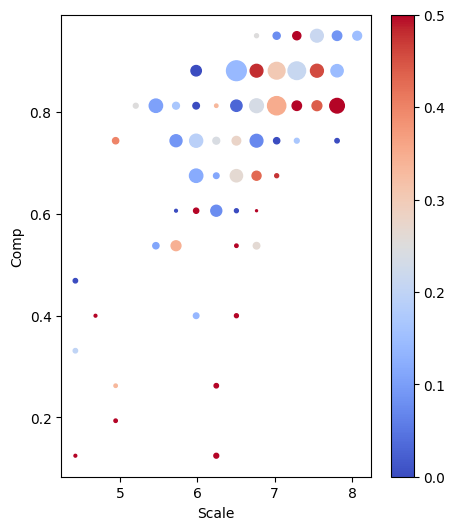

In [98]:
x_cols = ['Scale','Comp']
y_col = 'predecessor_assassination'
Xy = dataset_plot[[y_col]+x_cols].dropna()

x = Xy["Scale"].values
y = Xy["Comp"].values
z = Xy["predecessor_assassination"].values

grid_size = 15

df = pd.DataFrame({'x': x, 'y': y, 'z': z})

# Define the grid
x_bins = np.linspace(min(x), max(x), grid_size + 1)
y_bins = np.linspace(min(y), max(y), grid_size + 1)

# Bin the data
df['x_bin'] = pd.cut(df['x'], bins=x_bins, labels=False, include_lowest=True)
df['y_bin'] = pd.cut(df['y'], bins=y_bins, labels=False, include_lowest=True)

x_bins = np.linspace(df.loc[df.x_bin == df.x_bin.min(),'x'].mean(),df.loc[df.x_bin == df.x_bin.max(),'x'].mean(), len(df.x_bin.unique()))
y_bins = np.linspace(df.loc[df.y_bin == df.y_bin.min(),'y'].mean(),df.loc[df.y_bin == df.y_bin.max(),'y'].mean(), len(df.y_bin.unique()))

# Group by the bins and calculate the mean of z
grid = df.groupby(['x_bin', 'y_bin'])['z'].mean().unstack()
grid_std = df.groupby(['x_bin', 'y_bin'])['z'].std().unstack()
counts = df.groupby(['x_bin', 'y_bin'])['z'].count().unstack()

fig, ax = plt.subplots(figsize=(5, 6))
x,y = np.meshgrid(x_bins, y_bins)
plt.scatter(x.flatten(), y.flatten(), c=grid.T.values.flatten(), cmap='coolwarm', s=counts.T.values.flatten()*2, vmax = 0.5)
plt.colorbar()
plt.xlabel('Scale')

plt.ylabel('Comp')
# plt.title(crisis_vars)
plt.show()